# Problem Set 1: Gaussian Mixture Models for Image Patches

In this notebook, you will implement and analyze Gaussian Mixture Models (GMMs) for modeling natural image patches, and use them for image denoising.

**Instructions:**
- Look for `# TODO` comments indicating where you need to write code
- Questions requiring written answers are in **Markdown cells** - double-click to edit
- Each TODO corresponds to a specific sub-problem in the problem set
- Run all cells in order; some later cells depend on earlier ones

**References:**
- Zoran & Weiss, "Natural Images, Gaussian Mixtures and Dead Leaves" (NIPS 2012)

---
## Google Colab & GPU Usage Best Practices

*These instructions have been borrowed courtesy of https://www.cs.cornell.edu/courses/cs5670/2025sp*

### Using Google Colab
Google Colab is a cloud-based platform for running Python code, similar to Jupyter Notebooks. It requires no installation and saves your work directly to your Google Drive, just like Docs or Sheets.

We recommend using a Colab notebook with **GPU enabled** to complete this project efficiently.

**Note:** Colab has a free usage limit. If you're running long training sessions—especially close to the deadline—you may encounter resource restrictions. Some students work around this by:
- Using a different Google account (within Google's usage policies)
- Upgrading to Colab Pro (a paid option) for extended runtime and better resources

### Colab Setup:
1. Upload this `.ipynb` notebook template to your Google Drive
2. Double clicking on the notebook on Google Drive should give you an option for opening it in Colab
3. Alternatively, you can directly open Colab and upload notebook following this: `File -> Upload notebook...`
4. If you haven't used Colab or Jupyter Notebooks before, first read the [Colaboratory welcome guide](https://colab.research.google.com/notebooks/intro.ipynb)
5. Colab requires almost no setup, so there is no need to install PyTorch locally

### 💡 Pro Tips for GPU Usage:
- **Debug on CPU first!** Use CPU mode to test your code logic before switching to GPU. This avoids wasting GPU credits on buggy code.
- To enable GPU: `Runtime -> Change runtime type -> Hardware accelerator -> GPU`
- Only switch to GPU when you're ready for full training runs
- If you run out of GPU quota, wait or try a different Google account

## Setup and Imports

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm
import os
import urllib.request

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


## Data Loading

Load the preprocessed BSDS500 patches. The data has been preprocessed to:
- Extract 16x16 grayscale patches
- Normalize to [0, 1]
- Remove DC component (subtract mean from each patch)

In [2]:
# Mount google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls /content/drive/MyDrive/

BASE_DIR = "/content/drive/MyDrive/ct-courses-2026sp/cs5788/hw1"

if not os.path.exists(BASE_DIR):
    print(f"Creating {BASE_DIR}")
    os.makedirs(BASE_DIR)

'0830 son'
'0830 정산.gsheet'
'ADS Final Project - Harambe.pdf'
'AML final project'
'Book report.gslides'
 Career
'Charles Wiecha 02052025.gdoc'
'Colab Notebooks'
'Cornell Tech Resume Jiho Hahn.docx'
 CS5787_DL_Final_Project
'CS5787 DL Final report.gdoc'
 ct-courses-2026sp
 CT课程评价.xlsx
 ece5545
 ex1_jh2982_ab2382
 ex2_jh2982_ies22
 KCSA
'KCSA game night chip.gsheet'
'KCSA Korean Culture & Student Association at Cornell Tech (1).png'
'Resume Jiho Hahn.docx'
'Untitled document.gdoc'
'Untitled spreadsheet.gsheet'


In [4]:
# Download the files that you'll need
base_url = 'https://www.cs.cornell.edu/courses/cs5788/2026sp/data'

for name in ['patches_train.npy', 'patches_test.npy', 'test_images.npy']:
    if os.path.exists(f"{BASE_DIR}/{name}"):
        print(f"{name} already exists. Skip downloading")
        continue
    with open(f"{BASE_DIR}/{name}", 'wb') as out:
        url = os.path.join(base_url, name)
        out.write(urllib.request.urlopen(url).read())

patches_train.npy already exists. Skip downloading
patches_test.npy already exists. Skip downloading
test_images.npy already exists. Skip downloading


In [5]:
# Load preprocessed data
patches_train = np.load(f"{BASE_DIR}/patches_train.npy")
patches_test = np.load(f"{BASE_DIR}/patches_test.npy")
test_images = np.load(f"{BASE_DIR}/test_images.npy", allow_pickle=True)

print(f"Training patches: {patches_train.shape}")
print(f"Test patches: {patches_test.shape}")
print(f"Test images: {len(test_images)} images")

# Patch dimensions
PATCH_DIM = 16
PATCH_SIZE = PATCH_DIM * PATCH_DIM  # 256

# Convert to PyTorch tensors for later use
patches_train_tensor = torch.tensor(patches_train, dtype=torch.float32)
patches_test_tensor = torch.tensor(patches_test, dtype=torch.float32)

Training patches: (400000, 256)
Test patches: (100000, 256)
Test images: 10 images


### Visualize some training patches

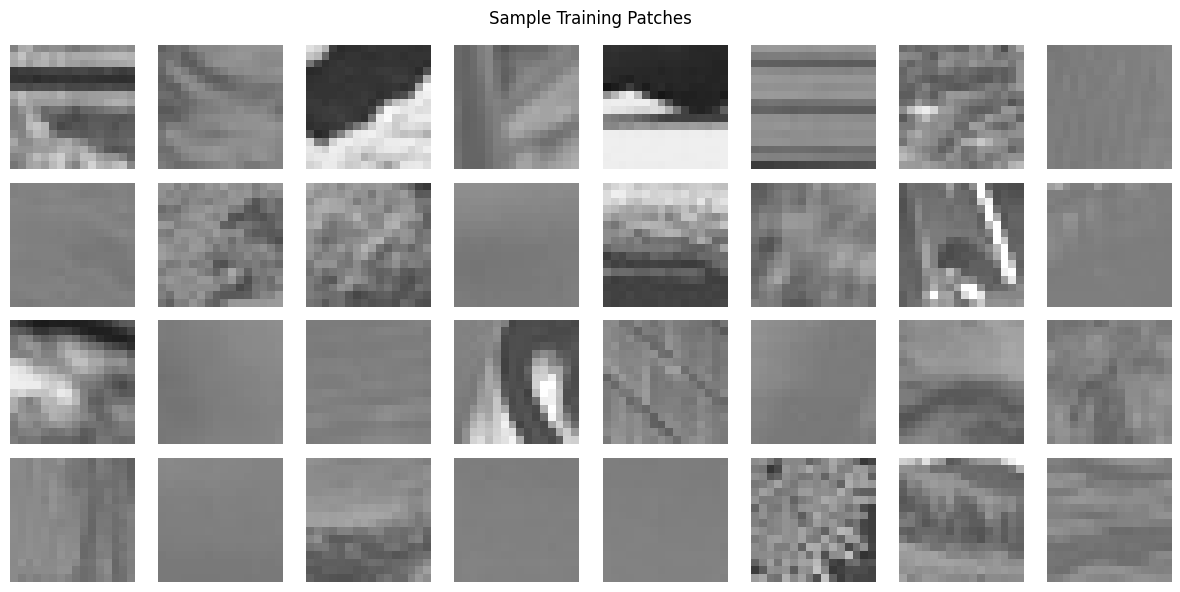

In [6]:
def visualize_patches(patches, nrows=4, ncols=8, title="Patches"):
    """Visualize a grid of patches."""
    n = nrows * ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 1.5, nrows * 1.5))
    for i, ax in enumerate(axes.flat):
        if i < n and i < len(patches):
            patch = patches[i]
            if len(patch.shape) == 1:
                patch = patch.reshape(PATCH_DIM, PATCH_DIM)
            ax.imshow(patch + 0.5, cmap='gray', vmin=0, vmax=1)
        ax.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Visualize some training patches (add 0.5 since DC was removed)
visualize_patches(patches_train[:32], title="Sample Training Patches")

---
## Background: Maximum Likelihood Estimation for Gaussians

### Single Gaussian MLE

Given $N$ data points $\{\mathbf{x}_1, \ldots, \mathbf{x}_N\}$ where each $\mathbf{x}_i \in \mathbb{R}^D$, the Maximum Likelihood Estimates (MLE) for a single Gaussian distribution are:

**Mean:**
$$\hat{\boldsymbol{\mu}} = \frac{1}{N} \sum_{i=1}^N \mathbf{x}_i$$

**Covariance:**
$$\hat{\boldsymbol{\Sigma}} = \frac{1}{N} \sum_{i=1}^N (\mathbf{x}_i - \hat{\boldsymbol{\mu}})(\mathbf{x}_i - \hat{\boldsymbol{\mu}})^T$$

These closed-form solutions minimize the negative log-likelihood:
$$\text{NLL} = -\frac{1}{N} \sum_{i=1}^N \log \mathcal{N}(\mathbf{x}_i | \boldsymbol{\mu}, \boldsymbol{\Sigma})$$

---
## Helper Functions

### GMM Negative Log-Likelihood

We compute the negative log-likelihood of data under a Gaussian Mixture Model:
$$\text{NLL} = -\frac{1}{N} \sum_{i=1}^{N} \log \left( \sum_{k=1}^{K} \pi_k \mathcal{N}(x_i | \mu_k, \Sigma_k) \right)$$

The implementation uses:
- Matrix operations for computing differences and Mahalanobis distances
- Cholesky decomposition for numerical stability with covariance matrices

### Log-Determinant via Cholesky Decomposition

**Why use Cholesky?** Computing $\log|\Sigma|$ directly can be slow and numerically unstable. Instead, we take advantage of special properties of the covariance matrix $\Sigma$ (symmetric and positive definite) and use the Cholesky decomposition (which only works with symmetric and positive definite matrices).

**Derivation:**

For a positive definite matrix $\Sigma$, the Cholesky decomposition gives us a **lower triangular** matrix $L$ such that:
$$\Sigma = LL^T$$

Taking the determinant of both sides:
$$|\Sigma| = |LL^T| = |L| \cdot |L^T| = |L|^2$$

For a triangular matrix, the determinant is the product of diagonal elements:
$$|L| = \prod_{i=1}^{D} L_{ii}$$

Therefore:
$$|\Sigma| = \left(\prod_{i=1}^{D} L_{ii}\right)^2$$

Taking the logarithm:
$$\log|\Sigma| = 2 \log\left(\prod_{i=1}^{D} L_{ii}\right) = 2 \sum_{i=1}^{D} \log(L_{ii})$$

In code: `log_det = 2 * sum(log(diag(L)))`

This is numerically stable because we only need the diagonal elements of $L$, and we work in log-space.

### Background: Symmetric and Positive-Definite Matrices

**Symmetric Matrix:** A matrix $A \in \mathbb{R}^{n \times n}$ is **symmetric** if $A = A^T$, meaning $A_{ij} = A_{ji}$ for all $i, j$.

**Positive-Definite Matrix:** A symmetric matrix $A$ is **positive-definite** if for all non-zero vectors $\mathbf{x} \in \mathbb{R}^n$:
$$\mathbf{x}^T A \mathbf{x} > 0$$

A matrix is **positive semi-definite** if $\mathbf{x}^T A \mathbf{x} \geq 0$ (allowing equality).

---

### Why Covariance Matrices Are Symmetric and Positive Semi-Definite

**Definition of Covariance Matrix:**
$$\Sigma = \mathbb{E}[(\mathbf{X} - \boldsymbol{\mu})(\mathbf{X} - \boldsymbol{\mu})^T]$$

**Proof of Symmetry:**
$$\Sigma^T = \mathbb{E}[(\mathbf{X} - \boldsymbol{\mu})(\mathbf{X} - \boldsymbol{\mu})^T]^T = \mathbb{E}[((\mathbf{X} - \boldsymbol{\mu})(\mathbf{X} - \boldsymbol{\mu})^T)^T] = \mathbb{E}[(\mathbf{X} - \boldsymbol{\mu})(\mathbf{X} - \boldsymbol{\mu})^T] = \Sigma$$

**Proof of Positive Semi-Definiteness:**
For any vector $\mathbf{v} \in \mathbb{R}^n$:
$$\mathbf{v}^T \Sigma \mathbf{v} = \mathbf{v}^T \mathbb{E}[(\mathbf{X} - \boldsymbol{\mu})(\mathbf{X} - \boldsymbol{\mu})^T] \mathbf{v} = \mathbb{E}[\mathbf{v}^T(\mathbf{X} - \boldsymbol{\mu})(\mathbf{X} - \boldsymbol{\mu})^T\mathbf{v}]$$

Let $Y = \mathbf{v}^T(\mathbf{X} - \boldsymbol{\mu})$, which is a scalar. Then:
$$\mathbf{v}^T \Sigma \mathbf{v} = \mathbb{E}[Y^2] \geq 0$$

Since the expectation of a squared quantity is always non-negative, $\Sigma$ is positive semi-definite.

**Note:** In practice, we add a small regularization term $\varepsilon I$ to ensure the covariance is strictly positive-definite (all eigenvalues $> 0$), which guarantees the Cholesky decomposition to exist.

In [7]:
def gmm_nll(mix, mu, cov, data, batch_size=10000):
    """
    Compute GMM negative log-likelihood with FULL covariance.
    Uses Cholesky decomposition for numerical stability.

    Args:
        mix: Mixture weights (K,)
        mu: Means (K, D)
        cov: Full covariance matrices (K, D, D)
        data: Data points (N, D)

    Returns:
        Scalar NLL loss

    HINT for computing Mahalanobis distance without einsum:
    1. diff = x[:, None, :] - mu[None, :, :]  gives (N, K, D)
    2. Use Cholesky: L = cholesky(cov), then solve L @ z = diff
    3. Mahalanobis = ||z||^2 = sum(z^2)
    """

    num_batches = data.shape[0] // batch_size
    nll = 0

    for i in range(num_batches):

        x = data[i * batch_size : (i + 1) * batch_size]
        N, D = x.shape
        K = mix.shape[0]

        # Compute difference: (N, K, D)
        diff = x[:, None, :] - mu[None, :, :]

        # Cholesky decomposition for numerical stability
        L = torch.linalg.cholesky(cov)  # (K, D, D)

        # Log determinant: log|cov| = 2 * sum(log(diag(L)))
        log_det = 2 * torch.sum(torch.log(torch.diagonal(L, dim1=1, dim2=2)), dim=1)  # (K,)

        # Mahalanobis distance using triangular solve
        # Reshape for batch solve: diff is (N, K, D), need (K, N, D)
        diff_flat = diff.permute(1, 0, 2)  # (K, N, D)

        # Solve L @ z = diff^T for each component
        solved = torch.linalg.solve_triangular(L, diff_flat.transpose(1, 2), upper=False)  # (K, D, N)

        # Mahalanobis = sum of squared elements
        mahal = torch.sum(solved ** 2, dim=1).T  # (N, K)

        # Log probability
        log_norm = -0.5 * (D * np.log(2 * np.pi) + log_det)  # (K,)
        log_mix = torch.log(mix + 1e-12)  # (K,)
        log_prob_components = log_mix[None, :] + log_norm[None, :] - 0.5 * mahal  # (N, K)

        # Log-sum-exp over components
        log_prob = torch.logsumexp(log_prob_components, dim=1)
        nll -= torch.mean(log_prob) / num_batches

    return nll

### GMM Training Function

We parameterize the covariance as $\Sigma = AA^T + \epsilon I$ to ensure positive semi-definiteness.

The training returns:
- `mix`: (K,) mixture weights
- `mu`: (K, D) means
- `cov`: (K, D, D) covariance matrices
- `L`: (K, D, D) Cholesky factors (where cov ≈ L @ L^T)

In [8]:
def train_gmm_full_cov(patches_train, K, num_epochs=10, batch_size=512, lr=1e-4, device='cpu', verbose=True, eps=1e-4):
    """
    Train GMM with FULL covariance using A*A^T + εI parameterization.

    Args:
        patches_train: Training data (N, D)
        K: Number of mixture components
        num_epochs: Number of training epochs
        batch_size: Batch size
        lr: Learning rate
        device: 'cpu' or 'cuda'
        verbose: Print progress
        eps: Regularization constant

    Returns:
        Dictionary with trained parameters and training history
    """
    N, D = patches_train.shape
    EPS = eps

    # Reset seeds for reproducibility
    np.random.seed(42 + K)  # Different seed per K for variety, but reproducible
    torch.manual_seed(42 + K)

    # =========================================================================
    # TODO: Initialize parameters
    # =========================================================================
    # 1. Initialize means mu (K, D) by randomly sampling K data points from training set
    #    HINT: Use np.random.choice() to select indices without replacement
    #
    # 2. Initialize A matrices (K, D, D) for covariance Σ = AA^T + εI
    #    HINT: Start with scaled identity matrices. Scale based on data variance.
    #
    # 3. Initialize mixture logits to zeros (for uniform initial weights)
    #    HINT: softmax(zeros) = uniform distribution
    # =========================================================================

    indices = np.random.choice(N, size=K, replace=False)
    mu = torch.tensor(patches_train[indices], dtype=torch.float32, device=device, requires_grad=True)

    data_std = np.std(patches_train, axis=0).mean()
    A = torch.eye(D, device=device).unsqueeze(0).repeat(K, 1, 1) * data_std

    mix_logits = torch.zeros(K, device=device, requires_grad=True)

    # Optimizer
    optimizer = torch.optim.Adam([mu, mix_logits, A], lr=lr)

    # Convert data to tensor once
    data_tensor = torch.tensor(patches_train, dtype=torch.float32, device=device)

    # Pre-compute identity matrix for regularization
    eye_D = torch.eye(D, device=device)

    history = {'train_nll': []}

    iterator = tqdm(range(num_epochs), desc=f'Training K={K} Full Cov') if verbose else range(num_epochs)
    for epoch in iterator:
        perm = torch.randperm(N, device=device)
        epoch_loss = 0
        n_batches = 0

        for start in range(0, N, batch_size):
            end = min(start + batch_size, N)
            idx = perm[start:end]
            x_batch = data_tensor[idx]  # (batch_N, D)
            batch_N = x_batch.shape[0]

            optimizer.zero_grad()

            # =========================================================================
            # TODO: Compute forward pass
            # =========================================================================
            # 1. Compute mixture weights from logits using softmax
            #
            # 2. Compute FULL covariance matrices: Σ = AA^T + εI
            #    HINT: Use torch.bmm() for batch matrix multiplication
            #
            # 3. Compute NLL using Cholesky decomposition:
            #    - Compute Cholesky factor L of covariance
            #    - log|Σ| = 2 * sum(log(diag(L)))
            #    - Compute Mahalanobis distance via triangular solve
            #      HINT: Use torch.linalg.solve_triangular() to solve L @ z = diff
            #    - Combine into log probability and use logsumexp
            #    - loss = -mean(log_prob)
            # =========================================================================

            # 1. Compute mixture weights
            mix = torch.softmax(mix_logits, dim=0)  # (K,)

            # 2. Compute full covariance matrices: Σ = AA^T + εI
            cov = torch.bmm(A, A.transpose(1, 2)) + EPS * eye_D.unsqueeze(0)  # (K, D, D)

            # 3. Compute NLL using Cholesky decomposition
            # Compute Cholesky factor
            L = torch.linalg.cholesky(cov)  # (K, D, D)

            # Compute log determinant: log|Σ| = 2 * sum(log(diag(L)))
            log_det = 2 * torch.sum(torch.log(torch.diagonal(L, dim1=1, dim2=2)), dim=1)  # (K,)

            # Compute differences: x - mu
            diff = x_batch.unsqueeze(0) - mu.unsqueeze(1)  # (K, batch_N, D)

            # Solve L @ z = diff for z using triangular solve
            # Reshape for solve_triangular: (K*batch_N, D, 1)
            diff_flat = diff.reshape(K * batch_N, D, 1)
            L_expanded = L.unsqueeze(1).expand(K, batch_N, D, D).reshape(K * batch_N, D, D)
            z = torch.linalg.solve_triangular(L_expanded, diff_flat, upper=False)  # (K*batch_N, D, 1)
            z = z.reshape(K, batch_N, D)

            # Compute Mahalanobis distance: z^T z
            mahal_dist = torch.sum(z ** 2, dim=2)  # (K, batch_N)

            # Compute log probability for each component
            log_prob_components = torch.log(mix).unsqueeze(1) - 0.5 * (D * np.log(2 * np.pi) + log_det.unsqueeze(1) + mahal_dist)  # (K, batch_N)

            # Compute total log probability using logsumexp
            log_prob = torch.logsumexp(log_prob_components, dim=0)  # (batch_N,)

            # Compute loss (negative log likelihood)
            loss = -torch.mean(log_prob)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            n_batches += 1

        avg_loss = epoch_loss / n_batches
        history['train_nll'].append(avg_loss)

        if verbose:
            iterator.set_postfix({'NLL': f'{avg_loss:.2f}'})

    # Build final covariance matrices and Cholesky factors
    with torch.no_grad():
        mix_final = torch.softmax(mix_logits, dim=0)
        cov_final = torch.bmm(A, A.transpose(1, 2)) + EPS * eye_D.unsqueeze(0)
        L_final = torch.linalg.cholesky(cov_final)

    return {
        'mix': mix_final.cpu(),
        'mu': mu.detach().cpu(),
        'cov': cov_final.cpu(),
        'L': L_final.cpu(),
        'A': A.detach().cpu(),
        'history': history,
        'eps': EPS
    }


def unpack_cholesky(L):
    """
    Unpack covariance matrix from its Cholesky factor.
    Given L (lower triangular), returns cov = L @ L^T
    """
    if L.dim() == 2:
        return L @ L.T
    else:
        return torch.bmm(L, L.transpose(1, 2))

### Sampling Function

In [9]:
def sample_from_gmm(mix, mu, cov, n_samples):
    """Sample from a GMM."""
    K = len(mix)
    mix_np = mix.detach().numpy()
    mu_np = mu.detach().numpy()
    cov_np = cov.detach().numpy()

    # Sample component indices
    component_idx = np.random.choice(K, size=n_samples, p=mix_np)

    # Sample from each component
    samples = np.zeros((n_samples, mu_np.shape[1]))
    for i in range(n_samples):
        k = component_idx[i]
        samples[i] = np.random.multivariate_normal(mu_np[k], cov_np[k])

    return samples

---
## Problem 1.1(a): Closed-form Solution for Single Gaussian

**Task:** Estimate $\boldsymbol{\mu}$ and $\boldsymbol{\Sigma}$ using the closed-form MLE solutions:

$$\hat{\boldsymbol{\mu}} = \frac{1}{N} \sum_{i=1}^N \mathbf{x}_i$$

$$\hat{\boldsymbol{\Sigma}} = \frac{1}{N} \sum_{i=1}^N (\mathbf{x}_i - \hat{\boldsymbol{\mu}})(\mathbf{x}_i - \hat{\boldsymbol{\mu}})^T$$

In [10]:
# Problem 1.1(a): Closed-form solution

# =========================================================================
# TODO: Compute closed-form mean
# HINT: Use .mean() with appropriate axis
# =========================================================================
mu_closed = patches_train.mean(axis=0)

# =========================================================================
# TODO: Compute closed-form covariance
# HINT: Use np.cov() - check the documentation for the correct parameters
#       to get MLE estimate (use the variance that divides by N)
# =========================================================================
cov_closed = np.cov(patches_train, rowvar=False, bias=True) # bias=True for MLE (divide by N, not N-1)

# --- Check that TODOs are completed ---
assert mu_closed is not None, "TODO: Implement closed-form mean above"
assert cov_closed is not None, "TODO: Implement closed-form covariance above"

# Add regularization for numerical stability
EPS_REG = 1e-4
cov_closed = cov_closed + EPS_REG * np.eye(PATCH_SIZE)

print(f"Mean shape: {mu_closed.shape}")
print(f"Covariance shape: {cov_closed.shape}")

# Evaluate on test set
mu_closed_tensor = torch.tensor(mu_closed, dtype=torch.float32).unsqueeze(0)
cov_closed_tensor = torch.tensor(cov_closed, dtype=torch.float32).unsqueeze(0)
mix_single = torch.ones(1)

nll_train_closed = gmm_nll(mix_single, mu_closed_tensor, cov_closed_tensor, patches_train_tensor)
nll_test_closed = gmm_nll(mix_single, mu_closed_tensor, cov_closed_tensor, patches_test_tensor)

print(f"\nClosed-form Single Gaussian:")
print(f"  Train NLL: {nll_train_closed.item():.4f}")
print(f"  Test NLL:  {nll_test_closed.item():.4f}")

Mean shape: (256,)
Covariance shape: (256, 256)

Closed-form Single Gaussian:
  Train NLL: -405.4577
  Test NLL:  -394.6541


---
## Problem 1.1(b): Visualize Top 10 Eigenvectors

**Task:** To help understand what the model is capturing, compute the eigendecomposition of the covariance matrix and visualize the top 10 eigenvectors.

The eigenvectors represent the principal directions of variation in the data. For natural image patches, these should resemble Fourier/DCT basis functions.

**Background on DCT/Fourier bases:**
- The **Discrete Cosine Transform (DCT)** and **Fourier Transform** decompose signals into sinusoidal components at different frequencies
- DCT/Fourier basis functions look like 2D sinusoidal waves with varying frequencies and orientations
- Low-frequency bases are smooth and slowly varying; high-frequency bases have rapid oscillations
- Natural images have statistics that are approximately **translation-invariant** (shifting a patch doesn't fundamentally change its statistics)
- For translation-invariant processes, the eigenvectors of the covariance matrix are exactly the Fourier/DCT basis functions

<>:26: SyntaxWarning: invalid escape sequence '\l'
<>:26: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-2369499966.py:26: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f'$\lambda_{{{i+1}}}$ = {eigenvalues[i]:.3f}')


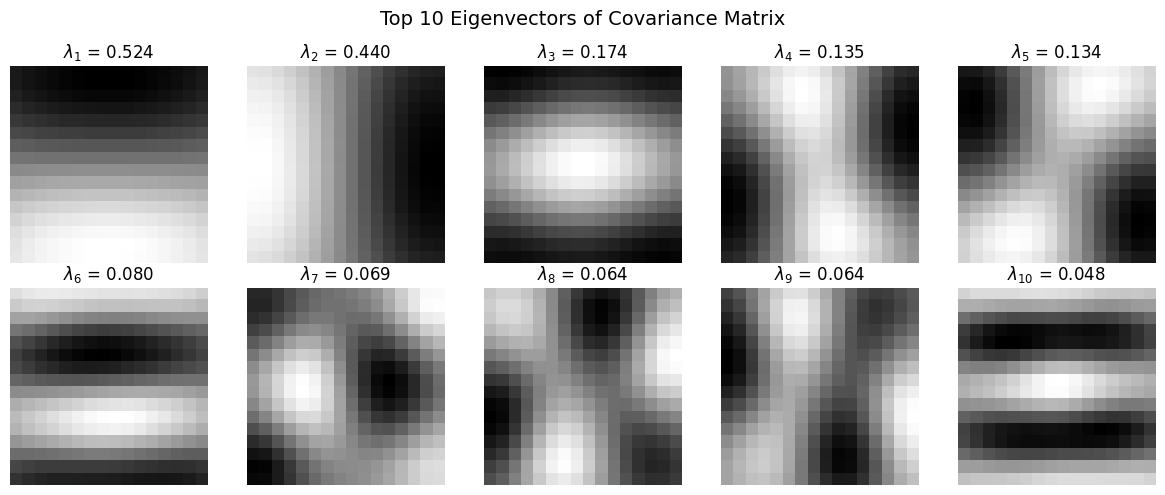

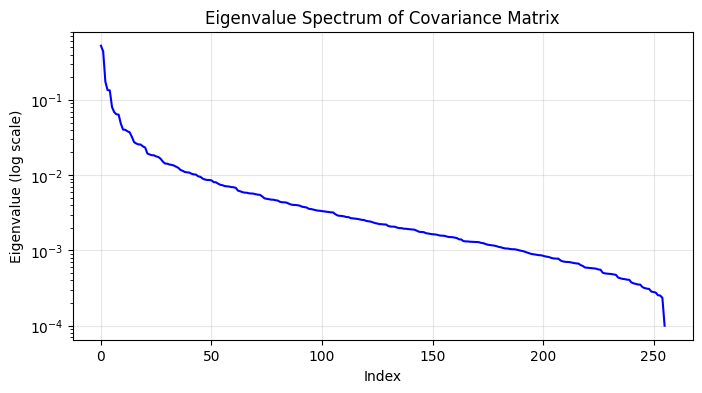

In [11]:
# Problem 1.1(b): Visualize top 10 eigenvectors

# =========================================================================
# TODO: Compute eigendecomposition
# HINT: Use np.linalg.eigh() for symmetric matrices
# NOTE: np.linalg.eigh() returns eigenvalues in ASCENDING order!
# =========================================================================
eigenvalues, eigenvectors = np.linalg.eigh(cov_closed)

# =========================================================================
# TODO: Sort eigenvalues and eigenvectors in DESCENDING order
# HINT: Use np.argsort() with [::-1] to reverse, then index both arrays
# =========================================================================
idx_desc = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx_desc]
eigenvectors = eigenvectors[:, idx_desc]

# --- Check that TODOs are completed ---
assert eigenvalues is not None, "TODO: Implement eigendecomposition above"

# Plot top 10 eigenvectors
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    eigvec = eigenvectors[:, i].reshape(PATCH_DIM, PATCH_DIM)
    ax.imshow(eigvec, cmap='gray')
    ax.set_title(f'$\lambda_{{{i+1}}}$ = {eigenvalues[i]:.3f}')
    ax.axis('off')
plt.suptitle('Top 10 Eigenvectors of Covariance Matrix', fontsize=14)
plt.tight_layout()
plt.show()

# Plot eigenvalue spectrum
plt.figure(figsize=(8, 4))
plt.semilogy(eigenvalues, 'b-')
plt.xlabel('Index')
plt.ylabel('Eigenvalue (log scale)')
plt.title('Eigenvalue Spectrum of Covariance Matrix')
plt.grid(True, alpha=0.3)
plt.show()

### TODO: Describe the eigenvectors (Problem 1.1(b))

**Question:** Describe the appearance of the eigenvectors in words. Consider:
- Do they look like smooth waves? Sharp edges? Random noise?
- How do they relate to the DCT/Fourier bases described above?

**Your Answer:** *(Double-click to edit this cell and write your answer here)*

...

---
## Problem 1.1(c): Covariance Structure Analysis

**Task:** Visualize the covariance between a fixed pixel and all other pixels.

This helps explain the connection between the eigenvalues and the Fourier/DCT bases.

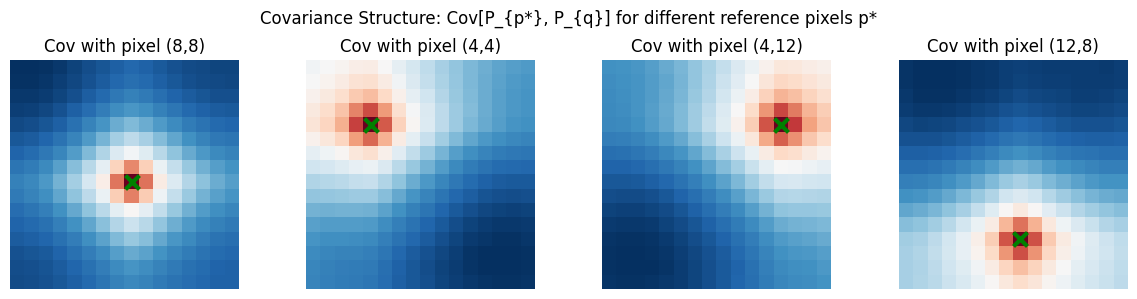

In [12]:
# Problem 1.1(c): Covariance structure visualization

# Pick a few reference pixels
ref_pixels = [
    (8, 8),   # Center
    (4, 4),   # Top-left quadrant
    (4, 12),  # Top-right quadrant
    (12, 8),  # Bottom center
]

fig, axes = plt.subplots(1, len(ref_pixels), figsize=(12, 3))
for i, (py, px) in enumerate(ref_pixels):
    # Convert 2D pixel location to 1D index
    p_idx = py * PATCH_DIM + px

    # Get covariance of this pixel with all others
    cov_row = cov_closed[p_idx, :].reshape(PATCH_DIM, PATCH_DIM)

    axes[i].imshow(cov_row, cmap='RdBu_r')
    axes[i].scatter([px], [py], c='green', s=100, marker='x', linewidths=3)
    axes[i].set_title(f'Cov with pixel ({py},{px})')
    axes[i].axis('off')

plt.suptitle('Covariance Structure: Cov[P_{p*}, P_{q}] for different reference pixels p*', fontsize=12)
plt.tight_layout()
plt.show()

### TODO: Describe the covariance structure (Problem 1.1(c))

**Question:** Describe what you observe about the covariance structure. Consider:
- Is it similar across different reference pixels?
- What does this suggest about the statistics of natural images?

**Your Answer:** *(Double-click to edit this cell and write your answer here)*

...

---
## Problem 1.1(d): SGD for Single Gaussian (K=1)

**Task:** Train a single Gaussian using stochastic gradient descent and compare to the closed-form solution.

Use:
- Batch size: 4096
- Learning rate: 1e-4
- Epochs: 20
- Regularization: ε = 1e-4

Training single Gaussian (K=1) with SGD...
Hyperparameters: batch_size=4096, lr=1e-4, num_epochs=20, eps=1e-4


Training K=1 Full Cov:   0%|          | 0/20 [00:00<?, ?it/s]


Comparison:
  Closed-form Test NLL: -394.6541
  SGD Test NLL:         -197.0743
  Difference:           197.5799


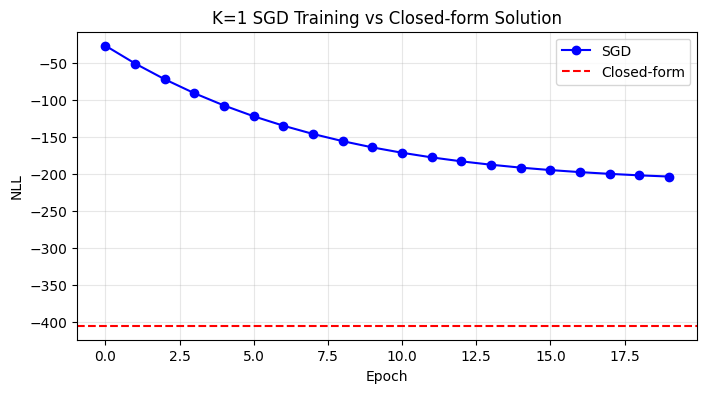

In [13]:
# Problem 1.1(d): Train single Gaussian with SGD
print("Training single Gaussian (K=1) with SGD...")
print("Hyperparameters: batch_size=4096, lr=1e-4, num_epochs=20, eps=1e-4")

# =========================================================================
# TODO: Train K=1 GMM using train_gmm_full_cov()
#
# Call train_gmm_full_cov() with the following arguments:
#   - patches_train: the training data
#   - K=1: number of components
#   - num_epochs=20: number of training epochs
#   - batch_size=4096: batch size
#   - lr=1e-4: learning rate
#   - device=device: 'cpu' or 'cuda'
#   - eps=1e-4: regularization constant
# =========================================================================
result_k1 = train_gmm_full_cov(
    patches_train,
    K=1,
    num_epochs=20,
    batch_size=4096,
    lr=1e-4,
    device=device,
    eps=1e-4,
)

# --- Check that TODO is completed ---
assert result_k1 is not None, "TODO: Call train_gmm_full_cov() above"

# Evaluate on test set
test_nll_sgd_k1 = gmm_nll(result_k1['mix'], result_k1['mu'], result_k1['cov'], patches_test_tensor)

print(f"\nComparison:")
print(f"  Closed-form Test NLL: {nll_test_closed.item():.4f}")
print(f"  SGD Test NLL:         {test_nll_sgd_k1.item():.4f}")
print(f"  Difference:           {abs(nll_test_closed.item() - test_nll_sgd_k1.item()):.4f}")

# Plot training curve
plt.figure(figsize=(8, 4))
plt.plot(result_k1['history']['train_nll'], 'b-o', label='SGD')
plt.axhline(y=nll_train_closed.item(), color='r', linestyle='--', label='Closed-form')
plt.xlabel('Epoch')
plt.ylabel('NLL')
plt.title('K=1 SGD Training vs Closed-form Solution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

---
## Problem 1.1(e): GMM with K=16

**Task:** Train a GMM with K=16 components and compare to K=1.

---
### Warm-up: 2-Component GMM (K=2)

Before training with K=16, let's first visualize a simple 2-component GMM to build intuition about how mixture components specialize.

**Task:** Train a 2-component GMM and compare the eigenvector structure of both components:
- Display top 63 eigenvectors (9×7 grid) for each component
- Observe that both components have approximately the same eigenvectors (Fourier-like)

In [14]:
def visualize_figure4_style(result_k2, patch_dim=16):
    """
    Recreate Figure 4 from Zoran & Weiss paper.
    Shows eigenvectors (9x7 dense grid) for a 2-component GMM.
    """
    K = 2
    n_eigvec_cols, n_eigvec_rows = 9, 7  # 63 eigenvectors per component
    n_eigvecs = n_eigvec_cols * n_eigvec_rows
    border_width = 1

    fig, axes = plt.subplots(1, 2, figsize=(14, 8))
    colors = ['blue', 'red']

    for k in range(K):
        cov_k = result_k2['cov'][k].numpy()
        eigenvalues, eigenvectors = np.linalg.eigh(cov_k)

        idx = np.argsort(eigenvalues)[::-1]
        eigenvectors = eigenvectors[:, idx]

        grid_h = n_eigvec_rows * patch_dim + (n_eigvec_rows + 1) * border_width
        grid_w = n_eigvec_cols * patch_dim + (n_eigvec_cols + 1) * border_width
        eigvec_composite = np.ones((grid_h, grid_w)) * 0.5

        for i in range(n_eigvecs):
            row = i // n_eigvec_cols
            col = i % n_eigvec_cols
            eigvec = eigenvectors[:, i].reshape(patch_dim, patch_dim)
            eigvec_norm = eigvec / (np.abs(eigvec).max() + 1e-8)
            eigvec_display = (eigvec_norm + 1) / 2

            y_start = border_width + row * (patch_dim + border_width)
            x_start = border_width + col * (patch_dim + border_width)
            eigvec_composite[y_start:y_start+patch_dim, x_start:x_start+patch_dim] = eigvec_display

        axes[k].imshow(eigvec_composite, cmap='gray', vmin=0, vmax=1)
        axes[k].set_title(f'Component {k+1}: π = {result_k2["mix"][k].item():.4f}',
                         fontsize=12, color=colors[k])
        axes[k].axis('off')

    plt.suptitle('Figure 4 Style: 2-Component GMM Eigenvectors\n'
                 '(9×7 grid of eigenvectors sorted by decreasing eigenvalue)', fontsize=14)
    plt.tight_layout()
    plt.show()

Training K=2 GMM for eigenvector analysis...


Training K=2 Full Cov:   0%|          | 0/15 [00:00<?, ?it/s]


K=2 GMM trained:
  Component 1 weight: 0.5753
  Component 2 weight: 0.4247


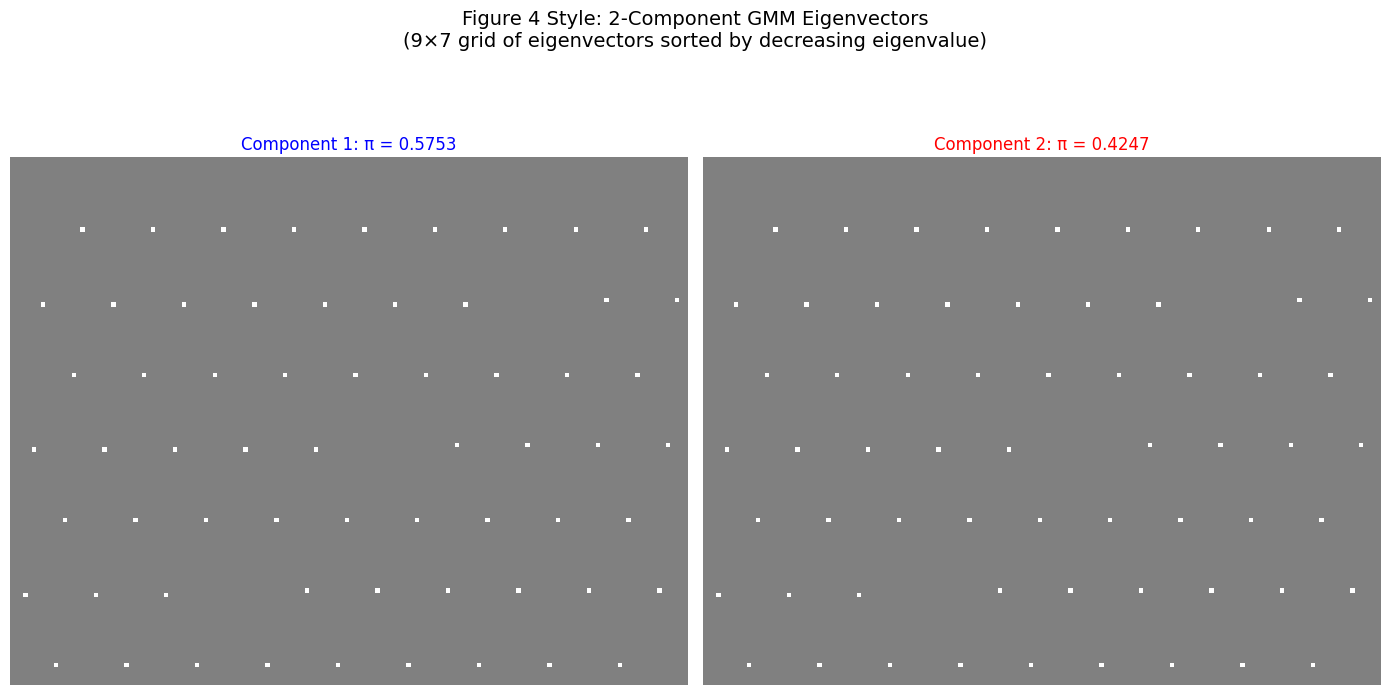

In [15]:
# Train K=2 GMM for eigenvector analysis
print("Training K=2 GMM for eigenvector analysis...")

# Train K=2 GMM
result_k2 = train_gmm_full_cov(patches_train, K=2, num_epochs=15, batch_size=4096,
                               lr=1e-4, device=device, eps=1e-4)

print(f"\nK=2 GMM trained:")
print(f"  Component 1 weight: {result_k2['mix'][0].item():.4f}")
print(f"  Component 2 weight: {result_k2['mix'][1].item():.4f}")

# Create Figure 4 style visualization
visualize_figure4_style(result_k2)

In [16]:
# Problem 1.1(e): Train GMM with K=16

# =========================================================================
# TODO: Train K=16 GMM using train_gmm_full_cov()
#
# Call train_gmm_full_cov() with the following arguments:
#   - patches_train: the training data
#   - K=16: number of components
#   - num_epochs=64: number of training epochs
#   - batch_size=4096: batch size
#   - lr=1e-4: learning rate
#   - device=device: 'cpu' or 'cuda'
#   - eps=1e-4: regularization constant
# =========================================================================
result_k16 = train_gmm_full_cov(
    patches_train,
    K=16,
    num_epochs=64,
    batch_size=4096,
    lr=1e-4,
    device=device,
    eps=1e-4,
)

# --- Check that TODO is completed ---
assert result_k16 is not None, "TODO: Train K=16 GMM above"

# Evaluate on test set
test_nll_k1 = gmm_nll(result_k1['mix'], result_k1['mu'], result_k1['cov'], patches_test_tensor)
test_nll_k16 = gmm_nll(result_k16['mix'], result_k16['mu'], result_k16['cov'], patches_test_tensor)

print(f"\nTest NLL Comparison:")
print(f"  K=1:  {test_nll_k1.item():.4f}")
print(f"  K=16: {test_nll_k16.item():.4f}")
print(f"  Improvement: {test_nll_k1.item() - test_nll_k16.item():.4f}")

Training K=16 Full Cov:   0%|          | 0/64 [00:00<?, ?it/s]


Test NLL Comparison:
  K=1:  -197.0743
  K=16: -239.6463
  Improvement: 42.5721


---
## Problem 1.1(f): Compare GMM vs Single Gaussian

**Task:** Explain why the GMM has lower NLL than the single Gaussian.

In [17]:
# Problem 1.1(f): Comparison
print("\n" + "="*50)
print("Comparison: Single Gaussian vs GMM (K=16)")
print("="*50)
print(f"Single Gaussian (K=1) Test NLL: {test_nll_k1.item():.4f}")
print(f"GMM K=16 Test NLL:              {test_nll_k16.item():.4f}")
print(f"\nImprovement (K=16 vs K=1): {test_nll_k1.item() - test_nll_k16.item():.4f}")


Comparison: Single Gaussian vs GMM (K=16)
Single Gaussian (K=1) Test NLL: -197.0743
GMM K=16 Test NLL:              -239.6463

Improvement (K=16 vs K=1): 42.5721


### TODO: Explain the NLL improvement (Problem 1.1(f))

**Question:** Explain why GMM with K=16 has lower NLL than the single Gaussian.

**Your Answer:** *(Double-click to edit this cell and write your answer here)*

...

---
## Problem 1.1(g): K Sweep

**Task:** Train models with K = 1, 4, 16, 32, 64 components. Plot NLL and visualize samples.

In [19]:
# Problem 1.1(g): Train models with different K values

K_values = [1, 4, 16, 32, 64]
results_full = {}

# =========================================================================
# TODO: Train GMMs for each K value using train_gmm_full_cov()
#
# For each K in K_values, call train_gmm_full_cov() with:
#   - patches_train: the training data
#   - K=K: current number of components
#   - num_epochs=64: fixed 64 epochs for all K
#   - batch_size=4096: batch size
#   - lr=1e-4: learning rate
#   - device=device: 'cpu' or 'cuda'
#   - eps=1e-4: regularization constant
#
# Store results in results_full dictionary: results_full[K] = result
# Also compute and store test NLL: results_full[K]['test_nll'] = test_nll.item()
# =========================================================================

for K in K_values:
    print(f"\nTraining K={K} with 64 epochs...")

    results_full[K] = train_gmm_full_cov(
        patches_train,
        K=K,
        num_epochs=64,
        batch_size=4096,
        lr=1e-4,
        device=device,
        eps=1e-4,
    )

    # --- Check that TODO is completed ---
    assert results_full[K] is not None, f"TODO: Train K={K} GMM"

    # Evaluate on test set
    test_nll = gmm_nll(results_full[K]['mix'], results_full[K]['mu'], results_full[K]['cov'], patches_test_tensor)
    results_full[K]['test_nll'] = test_nll.item()
    print(f"K={K} Test NLL: {test_nll.item():.4f}")


Training K=1 with 64 epochs...


Training K=1 Full Cov:   0%|          | 0/64 [00:00<?, ?it/s]

K=1 Test NLL: -203.3229

Training K=4 with 64 epochs...


Training K=4 Full Cov:   0%|          | 0/64 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.00 GiB. GPU 0 has a total capacity of 39.56 GiB of which 1.57 GiB is free. Process 33801 has 37.98 GiB memory in use. Of the allocated memory 37.10 GiB is allocated by PyTorch, and 355.63 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### (Optional) Save the trained models.

In [ ]:
torch.save(results_full, os.path.join(BASE_DIR, 'gmm_full_cov_results.pth'))

### (Optional) Load the trained models.

In [ ]:
results_full = torch.load(os.path.join(BASE_DIR, 'gmm_full_cov_results.pth'))

In [ ]:
# Plot NLL vs K
test_nlls = [results_full[K]['test_nll'] for K in K_values]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K_values, test_nlls, 'b-o', markersize=8, linewidth=2)
plt.xlabel('Number of Components (K)')
plt.ylabel('Test NLL')
plt.title('Test NLL vs Number of Components')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.semilogx(K_values, test_nlls, 'b-o', markersize=8, linewidth=2, base=2)
plt.xlabel('Number of Components (K, log scale)')
plt.ylabel('Test NLL')
plt.title('Test NLL vs K (log scale)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
print("\nSummary: Test NLL vs K")
print("-" * 40)
for K in K_values:
    print(f"K = {K:3d}: NLL = {results_full[K]['test_nll']:.4f}")

In [ ]:
# Visualize samples from each model
K_values_viz = [1, 4, 16, 64]
fig, axes = plt.subplots(len(K_values_viz), 8, figsize=(16, 2*len(K_values_viz)))

for row, K in enumerate(K_values_viz):
    samples = sample_from_gmm(results_full[K]['mix'], results_full[K]['mu'], results_full[K]['cov'], 8)
    samples = samples.reshape(-1, PATCH_DIM, PATCH_DIM)

    for col in range(8):
        axes[row, col].imshow(samples[col] + 0.5, cmap='gray', vmin=0, vmax=1)
        axes[row, col].set_xticks([])
        axes[row, col].set_yticks([])
        for spine in axes[row, col].spines.values():
            spine.set_visible(False)

    axes[row, 0].set_ylabel(f'K={K}', fontsize=12, rotation=0, labelpad=30, va='center')

plt.suptitle('Problem 1.1(g): Samples from GMMs with Different K', fontsize=14)
plt.tight_layout()
plt.show()

### TODO: Describe performance vs K (Problem 1.1(g))

**Question:** Describe how performance changes as the number of Gaussians in the mixture (i.e., K) increases, both:
- **Quantitatively:** How does test NLL change as K increases?
- **Qualitatively:** How do the samples look different for small vs large K?

**Your Answer:** *(Double-click to edit this cell and write your answer here)*

...

---
## Problem 1.1(h): Analyzing each component of the GMM

**Tasks:**
1. Analyze mixture weights for K=64
2. Identify texture and edge components
3. Visualize leading eigenvectors and samples
4. Show component assignments on natural images

In [ ]:
# Use K=64 model from results
result_k64 = results_full[64]

# Analyze mixture weights
mix_weights = result_k64['mix'].numpy()

print("\nMixture Weight Statistics (K=64):")
print(f"  Max weight: {mix_weights.max():.4f}")
print(f"  Min weight: {mix_weights.min():.4f}")
print(f"  Mean weight: {mix_weights.mean():.4f} (expected: {1/64:.4f})")
print(f"  Components with weight > 1%: {(mix_weights > 0.01).sum()}")

In [ ]:
def assign_patches_to_components(patches, mix, mu, cov):
    """
    Assign each patch to its most likely component.

    Returns:
        assignments: Array of component indices (N,)
        posteriors: Posterior probabilities P(k|x) for each patch (N, K)
    """
    N = len(patches)
    K = len(mix)
    D = patches.shape[1]

    # Convert to numpy if needed
    patches_np = patches if isinstance(patches, np.ndarray) else patches.numpy()
    mix_np = mix.numpy() if hasattr(mix, 'numpy') else mix
    mu_np = mu.numpy() if hasattr(mu, 'numpy') else mu
    cov_np = cov.numpy() if hasattr(cov, 'numpy') else cov

    # Initialize log probabilities array
    log_probs = np.zeros((N, K))

    # Compute log p(x, k) = log p(x|k) + log p(k) for each component
    for k in range(K):
        # =========================================================================
        # TODO: Compute log probability for component k
        # For each patch x, compute: log p(x|k) + log π_k
        #
        # The Gaussian log probability is:
        # log N(x|μ_k, Σ_k) = -0.5 * [D*log(2π) + log|Σ_k| + (x-μ_k)^T Σ_k^{-1} (x-μ_k)]
        #
        # HINTS:
        # - Use np.linalg.slogdet() to compute log determinant
        # - Use np.linalg.solve() to compute Σ_k^{-1} @ diff instead of inverting
        # - diff = patches_np - mu_np[k]  # (N, D)
        # - mahal = np.sum(diff * np.linalg.solve(cov_np[k] + 1e-6 * np.eye(D), diff.T).T, axis=1)
        # =========================================================================

        diff = patches_np - mu_np[k]  # (N, D)

        # Compute log determinant of covariance matrix
        sign, logdet = np.linalg.slogdet(cov_np[k] + 1e-6 * np.eye(D))

        mahal = np.sum(diff * np.linalg.solve(cov_np[k] + 1e-6 * np.eye(D), diff.T).T, axis=1)

        log_gauss = -0.5 * (D * np.log(2 * np.pi) + logdet + mahal)

        log_probs[:, k] = log_gauss + np.log(mix_np[k])


    # Convert to posteriors using softmax (provided - no TODO needed)
    log_probs_shifted = log_probs - np.max(log_probs, axis=1, keepdims=True)
    posteriors = np.exp(log_probs_shifted)
    posteriors = posteriors / np.sum(posteriors, axis=1, keepdims=True)

    # Get assignments (provided - no TODO needed)
    assignments = np.argmax(posteriors, axis=1)

    return assignments, posteriors

In [ ]:
def visualize_figure5_style(result, selected_components, patch_dim=16):
    """
    Create Figure 5 style visualization.
    For each selected component, show:
    - Top 64 eigenvectors (8×8 grid)
    - 64 samples (8×8 grid)
    """
    n_components = len(selected_components)
    if n_components == 0:
        print("No components to visualize!")
        return

    n_grid = 8
    n_items = n_grid * n_grid

    colors = ['#FF6B6B', '#77DD77', '#6B9FFF', '#FDFD96', '#DDA0DD', '#FFB347', '#87CEEB', '#98D8C8', '#F7DC6F', '#BB8FCE'][:n_components]

    fig, axes = plt.subplots(2, n_components, figsize=(4*n_components, 10))

    if n_components == 1:
        axes = axes.reshape(2, 1)

    for col, k in enumerate(selected_components):
        cov_k = result['cov'][k].numpy()
        eigenvalues, eigenvectors = np.linalg.eigh(cov_k)
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]f
        eigenvectors = eigenvectors[:, idx]

        # Debug: Print eigenvalue range for first component
        if col == 0:
            print(f"Component {k}: eigenvalue range [{eigenvalues.min():.2e}, {eigenvalues.max():.2e}]")
            print(f"  Top 5 eigenvalues: {eigenvalues[:5]}")

        # Top row: Eigenvectors
        eigvec_composite = np.zeros((n_grid * patch_dim, n_grid * patch_dim))
        for i in range(n_items):
            row = i // n_grid
            col_idx = i % n_grid
            eigvec = eigenvectors[:, i].reshape(patch_dim, patch_dim)
            # Normalize each eigenvector to [-1, 1] for display
            max_abs = np.abs(eigvec).max()
            if max_abs > 1e-10:
                eigvec_norm = eigvec / max_abs
            else:
                eigvec_norm = eigvec  # Avoid division issues
            eigvec_composite[row*patch_dim:(row+1)*patch_dim,
                           col_idx*patch_dim:(col_idx+1)*patch_dim] = eigvec_norm

        axes[0, col].imshow(eigvec_composite, cmap='gray', vmin=-1, vmax=1)
        axes[0, col].axis('off')
        axes[0, col].set_title(f'Component k={k}\nπ = {result["mix"][k].item():.4f}',
                               fontsize=11, color=colors[col], fontweight='bold')

        # Bottom row: Samples from the Gaussian
        mu_k = result['mu'][k].numpy()

        # Add small regularization to ensure sampling works
        cov_k_reg = cov_k + 1e-6 * np.eye(patch_dim * patch_dim)
        samples = np.random.multivariate_normal(mu_k, cov_k_reg, size=n_items)

        # Debug: Check sample variance for first component
        if col == 0:
            sample_std = samples.std()
            print(f"  Sample std dev: {sample_std:.4f}")

        sample_composite = np.zeros((n_grid * patch_dim, n_grid * patch_dim))
        for i in range(n_items):
            row = i // n_grid
            col_idx = i % n_grid
            sample = samples[i].reshape(patch_dim, patch_dim)
            # Add 0.5 to shift from zero-mean to [0, 1] display range
            sample_composite[row*patch_dim:(row+1)*patch_dim,
                           col_idx*patch_dim:(col_idx+1)*patch_dim] = sample + 0.5

        axes[1, col].imshow(np.clip(sample_composite, 0, 1), cmap='gray', vmin=0, vmax=1)
        axes[1, col].axis('off')

    axes[0, 0].set_ylabel('Eigenvectors\n(8×8 grid)', fontsize=12)
    axes[1, 0].set_ylabel('Samples\n(8×8 grid)', fontsize=12)

    plt.suptitle(f'Figure 5 Style: Eigenvectors and Samples from {n_components} GMM Components', fontsize=14)
    plt.tight_layout()
    plt.show()

    return colors

### Automatic Component Selection (Heuristic)

**DISCLAIMER:** The `identify_component_types_for_image()` function uses heuristics to automatically identify **texture** and **edge** components. However:
- It does **NOT** identify **flat/uniform** components - you must find these yourself!
- The heuristic may produce incorrect results depending on the trained model

**For this problem, you need to identify 3 components:**
1. **Edge** - The heuristic can help, or inspect eigenvectors with localized energy
2. **Flat/uniform** - Find this yourself! Look for components with low-variance, nearly constant eigenvectors
3. **Other** - Your choice! Describe what you see (could be texture, corners, gradients, etc.)

**Recommended approach:**
1. Run `visualize_figure5_style(result_k64, top_8_indices)` to inspect top components
2. Use the heuristic as a starting point for edges
3. Look for flat components (samples look uniform, eigenvectors have low variance)
4. Pick an interesting "other" component and describe it

In [ ]:
def identify_component_types_for_image(test_image, result, patch_size=16, stride=4, n_texture=2, n_edge=2):
    """
    Heuristic function to identify texture and edge components.

    WARNING: This is a heuristic and may not always produce correct results.
    Students should verify selections manually using visualize_figure5_style().

    Returns:
        selected_components: List of component indices (texture + edge)
        assignments: Patch assignments for the test image
        posteriors: Posterior probabilities
        patches: Extracted patches from test image
    """
    K = len(result['mix'])
    PATCH_DIM = patch_size
    H, W = test_image.shape

    # Extract patches from test image and assign to components
    patches = []
    for y in range(0, H - patch_size + 1, stride):
        for x in range(0, W - patch_size + 1, stride):
            patch = test_image[y:y+patch_size, x:x+patch_size]
            patch_flat = patch.flatten() - patch.mean()
            patches.append(patch_flat)
    patches = np.array(patches)

    # Assign patches to components
    assignments, posteriors = assign_patches_to_components(
        patches, result['mix'], result['mu'], result['cov']
    )

    # Count assignments per component
    assignment_counts = np.bincount(assignments, minlength=K)

    # Thresholds for minimum representation
    texture_min_count = len(patches) * 0.01   # 1% for textures
    edge_min_count = len(patches) * 0.005     # 0.5% for edges

    texture_candidates = []
    edge_candidates = []

    for k in range(K):
        cov_k = result['cov'][k].numpy()
        eigenvalues, eigenvectors = np.linalg.eigh(cov_k)
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]

        total_var = eigenvalues.sum()
        top_eigvec = eigenvectors[:, 0].reshape(PATCH_DIM, PATCH_DIM)

        # Check energy distribution for edge detection
        left_energy = np.abs(top_eigvec[:, :PATCH_DIM//2]).sum()
        right_energy = np.abs(top_eigvec[:, PATCH_DIM//2:]).sum()
        top_energy = np.abs(top_eigvec[:PATCH_DIM//2, :]).sum()
        bottom_energy = np.abs(top_eigvec[PATCH_DIM//2:, :]).sum()

        total_energy = np.abs(top_eigvec).sum()

        lr_ratio = max(left_energy, right_energy) / (total_energy + 1e-8)
        tb_ratio = max(top_energy, bottom_energy) / (total_energy + 1e-8)

        asymmetry = max(lr_ratio, tb_ratio)
        count = assignment_counts[k]

        if asymmetry > 0.55 and count >= edge_min_count:
            edge_candidates.append((k, asymmetry, total_var, count))
        elif count >= texture_min_count:
            texture_candidates.append((k, total_var, count, asymmetry))

    # Select components
    texture_candidates.sort(key=lambda x: (-x[2], -x[1]))
    selected_texture = [c[0] for c in texture_candidates[:n_texture]]

    edge_candidates.sort(key=lambda x: (-x[1], -x[3]))
    selected_edge = [c[0] for c in edge_candidates[:n_edge]]

    print(f"\n[Heuristic] Component selection:")
    print(f"  Texture candidates found: {len(texture_candidates)}")
    print(f"  Edge candidates found: {len(edge_candidates)}")
    print(f"  Selected texture components: {selected_texture}")
    print(f"  Selected edge components: {selected_edge}")
    print(f"\n⚠️  Please verify these selections manually!")

    return selected_texture + selected_edge, assignments, posteriors, patches

In [ ]:
# Example: Visualize the TOP 8 components by mixture weight
# These are the most important components (highest π values)
mix_weights = result_k64['mix'].numpy()
top_8_indices = np.argsort(mix_weights)[::-1][:8].tolist()  # Sort descending, take top 8

print("Visualizing TOP 8 components by mixture weight:")
print(f"Component indices: {top_8_indices}")
print(f"Mixture weights: {[f'{mix_weights[k]:.4f}' for k in top_8_indices]}")
print("(Look for: texture = Fourier-like patterns, edge = localized energy)")
_ = visualize_figure5_style(result_k64, top_8_indices)

In [ ]:
# =========================================================================
# TODO: Identify 3 components from the K=64 model
#
# Find components that capture each of the following image structures:
#   (1) Edges - sharp transitions between light and dark regions
#   (2) Flat/uniform regions - patches with little variation
#   (3) Other - any other type of content you find interesting (describe it!)
#
# HINTS:
# - Edge components have localized eigenvectors (energy on one side)
# - Flat components have low-variance eigenvectors (nearly constant)
# - Texture components have Fourier-like eigenvectors (periodic patterns)
#
# The heuristic function `identify_component_types_for_image()` can help
# identify texture and edge components, but you must find the FLAT
# component yourself by inspecting the visualizations above.
#
# After inspecting components, enter your chosen indices below.
# =========================================================================
selected_components = None  # TODO: e.g., [5, 12, 23] for edge, flat, other

# --- Check that TODO is completed ---
assert selected_components is not None, "TODO: Select 3 components (edge, flat, other) above"
assert len(selected_components) == 3, "TODO: You should select exactly 3 components"

# Visualize selected components
component_colors = visualize_figure5_style(result_k64, selected_components)

### Figure 6: Component Assignments on Natural Images

This visualization shows which GMM component is most likely for each patch location in a natural image.

In [ ]:
def visualize_figure6_style(test_image, result, selected_components, colors,
                            assignments, posteriors, patch_size=16, stride=4,
                            max_patches_per_component=40):
    """
    Recreate Figure 6: Component assignments on natural images.
    Shows spatially distributed patches for each component (non-overlapping within same component).
    """
    from matplotlib.patches import Rectangle

    H, W = test_image.shape

    # Get patch positions
    positions = []
    for y in range(0, H - patch_size + 1, stride):
        for x in range(0, W - patch_size + 1, stride):
            positions.append((y, x))

    positions = np.array(positions)
    print(f"Total patches: {len(positions)}")

    # Create visualization
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    ax.imshow(test_image, cmap='gray', vmin=0, vmax=1)

    # For each selected component, select spatially distributed patches
    stats = {}
    for color_idx, k in enumerate(selected_components):
        # Find patches assigned to this component
        component_mask = assignments == k
        component_indices = np.where(component_mask)[0]

        if len(component_indices) == 0:
            stats[k] = 0
            continue

        stats[k] = len(component_indices)

        # Get positions and posteriors for this component's patches
        component_positions = positions[component_indices]
        component_posteriors = posteriors[component_indices, k]

        # Greedy selection for spatial distribution (non-overlapping)
        n_select = min(max_patches_per_component, len(component_indices))
        selected_local = []
        selected_positions = []

        # Sort by posterior (descending) to prioritize high-confidence patches
        sorted_order = np.argsort(component_posteriors)[::-1]

        for idx in sorted_order:
            if len(selected_local) >= n_select:
                break

            pos = component_positions[idx]

            # Check if this patch overlaps with any already selected patch
            overlaps = False
            for sel_pos in selected_positions:
                # Patches overlap if their centers are within patch_size of each other
                if abs(pos[0] - sel_pos[0]) < patch_size and abs(pos[1] - sel_pos[1]) < patch_size:
                    overlaps = True
                    break

            if not overlaps:
                selected_local.append(idx)
                selected_positions.append(pos)

        # Draw rectangles for selected patches
        for idx in selected_local:
            global_idx = component_indices[idx]
            y, x = positions[global_idx]

            rect = Rectangle((x, y), patch_size, patch_size,
                            linewidth=2, edgecolor=colors[color_idx],
                            facecolor='none')
            ax.add_patch(rect)

    ax.axis('off')
    ax.set_title('Figure 6 Style: Component Assignments on Natural Image\n'
                 f'(Up to {max_patches_per_component} spatially distributed patches per component)')

    # Add legend
    legend_elements = [Rectangle((0,0), 1, 1, facecolor='none',
                                  edgecolor=colors[i], linewidth=3,
                                  label=f'Component {selected_components[i]}')
                      for i in range(len(selected_components))]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

    plt.tight_layout()
    plt.show()

    # Print assignment statistics
    print("\nComponent Assignment Statistics (total assigned / shown):")
    for i, k in enumerate(selected_components):
        total = stats.get(k, 0)
        pct = 100 * total / len(assignments)
        print(f"  Component {k} ({colors[i]}): {total} total ({pct:.1f}%)")

In [ ]:
# Create Figure 6 visualization
print("\n" + "="*70)
print("Figure 6: Component Assignments on Natural Image")
print("="*70)

# Use first test image
test_img = test_images[0]
H, W = test_img.shape
patch_size = 16
stride = 4

# Extract patches from test image
patches_for_assignment = []
for y in range(0, H - patch_size + 1, stride):
    for x in range(0, W - patch_size + 1, stride):
        patch = test_img[y:y+patch_size, x:x+patch_size]
        patch_flat = patch.flatten() - patch.mean()
        patches_for_assignment.append(patch_flat)
patches_for_assignment = np.array(patches_for_assignment)

print(f"Extracted {len(patches_for_assignment)} patches from test image")

# Assign patches to components
assignments, posteriors = assign_patches_to_components(
    patches_for_assignment, result_k64['mix'], result_k64['mu'], result_k64['cov']
)

# Visualize Figure 6
visualize_figure6_style(
    test_img, result_k64, selected_components, component_colors,
    assignments, posteriors, patch_size=16, stride=4
)

In [ ]:
# Figure 6 on multiple test images
print("\n" + "="*70)
print("Figure 6: Component Assignments on Multiple Natural Images")
print("="*70)

n_images_to_show = min(4, len(test_images))

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

from matplotlib.patches import Rectangle

for img_idx in range(n_images_to_show):
    test_img = test_images[img_idx]
    H, W = test_img.shape

    # Extract patches
    patches_img = []
    positions_img = []
    for y in range(0, H - patch_size + 1, stride):
        for x in range(0, W - patch_size + 1, stride):
            patch = test_img[y:y+patch_size, x:x+patch_size]
            patch_flat = patch.flatten() - patch.mean()
            patches_img.append(patch_flat)
            positions_img.append((y, x))
    patches_img = np.array(patches_img)
    positions_img = np.array(positions_img)

    # Assign patches
    assignments_img, posteriors_img = assign_patches_to_components(
        patches_img, result_k64['mix'], result_k64['mu'], result_k64['cov']
    )

    # Draw on subplot
    ax = axes[img_idx]
    ax.imshow(test_img, cmap='gray', vmin=0, vmax=1)

    # Draw patches for each selected component
    for color_idx, k in enumerate(selected_components):
        component_mask = assignments_img == k
        component_indices = np.where(component_mask)[0]

        if len(component_indices) == 0:
            continue

        component_positions = positions_img[component_indices]
        component_posteriors = posteriors_img[component_indices, k]

        # Greedy selection for non-overlapping patches
        n_select = min(30, len(component_indices))
        selected_local = []
        selected_positions = []

        sorted_order = np.argsort(component_posteriors)[::-1]

        for idx in sorted_order:
            if len(selected_local) >= n_select:
                break
            pos = component_positions[idx]
            overlaps = False
            for sel_pos in selected_positions:
                if abs(pos[0] - sel_pos[0]) < patch_size and abs(pos[1] - sel_pos[1]) < patch_size:
                    overlaps = True
                    break
            if not overlaps:
                selected_local.append(idx)
                selected_positions.append(pos)

        for idx in selected_local:
            global_idx = component_indices[idx]
            y, x = positions_img[global_idx]
            rect = Rectangle((x, y), patch_size, patch_size,
                            linewidth=2, edgecolor=component_colors[color_idx], facecolor='none')
            ax.add_patch(rect)

    ax.set_title(f'Test Image {img_idx + 1}', fontsize=12)
    ax.axis('off')

# Add legend
legend_elements = [Rectangle((0,0), 1, 1, facecolor='none', edgecolor=component_colors[i],
                              linewidth=3, label=f'Component {selected_components[i]}')
                  for i in range(len(selected_components))]
fig.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.suptitle('Figure 6 Style: Component Assignments on Multiple Natural Images', fontsize=14)
plt.tight_layout()
plt.show()

---
---
# Problem 1.2: Image Denoising using GMM

We will use the GMM as an image prior for denoising.

**Setup:** Given noisy image $\mathbf{Y} = \mathbf{X}_0 + \sigma \boldsymbol{\epsilon}$ where $\sigma = 25/255$.

**Goal:** Recover clean image by minimizing:
$$\mathcal{L}(\hat{\mathbf{x}}) = \|\hat{\mathbf{x}} - \mathbf{y}\|^2 - \lambda \log q_\phi(\hat{\mathbf{x}})$$

where $\lambda = 2\sigma^2$.

## Problem 1.2(a): Patch Denoising with Gradient Descent

In [ ]:
def gmm_log_prob_full(x, mix, mu, cov):
    """
    Compute log probability under GMM with FULL covariance.
    Uses Cholesky decomposition for numerical stability.

    Args:
        x: (N, D) data points
        mix: (K,) mixture weights
        mu: (K, D) means
        cov: (K, D, D) full covariance matrices

    Returns:
        (N,) log probabilities
    """
    N, D = x.shape
    K = len(mix)
    device = x.device

    mix = mix.to(device)
    mu = mu.to(device)
    cov = cov.to(device)

    # Cholesky decomposition
    cov_reg = cov + 1e-6 * torch.eye(D, device=device).unsqueeze(0)
    L = torch.linalg.cholesky(cov_reg)

    # Log determinant
    log_det = 2 * torch.sum(torch.log(torch.diagonal(L, dim1=1, dim2=2)), dim=1)

    # Mahalanobis distance
    diff = x.unsqueeze(1) - mu.unsqueeze(0)  # (N, K, D)

    mahal = torch.zeros(N, K, device=device)
    for k in range(K):
        z = torch.linalg.solve_triangular(L[k], diff[:, k, :].T, upper=False)
        mahal[:, k] = (z ** 2).sum(dim=0)

    # Log probability
    log_norm = -0.5 * (D * np.log(2 * np.pi) + log_det)
    log_mix = torch.log(mix + 1e-12)
    log_prob_components = log_mix + log_norm - 0.5 * mahal

    return torch.logsumexp(log_prob_components, dim=1)

In [ ]:
def sgd_denoise_patches_full_cov(noisy_patches, mix, mu, cov, sigma,
                                  lambda_prior=None, num_iters=100, lr=0.1,
                                  batch_size=4096, verbose=True):
    """
    SGD-based patch denoising with FULL covariance support.

    Minimizes: L(x̂) = ||x̂ - y||² - λ log q(x̂)

    Args:
        noisy_patches: (N, D) noisy patches (numpy array)
        mix, mu, cov: GMM parameters (torch tensors)
        sigma: noise standard deviation
        lambda_prior: weight for prior term (default: 2σ²)
        num_iters: number of gradient descent iterations
        lr: learning rate
        batch_size: batch size for GPU processing
        verbose: show progress bar

    Returns:
        (N, D) denoised patches (numpy array)
    """
    N, D = noisy_patches.shape
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    if lambda_prior is None:
        lambda_prior = 2 * sigma ** 2

    mix_gpu = mix.to(device)
    mu_gpu = mu.to(device)
    cov_gpu = cov.to(device)

    all_denoised = []

    iterator = tqdm(range(0, N, batch_size), desc='SGD Full Cov') if verbose else range(0, N, batch_size)

    for start in iterator:
        end = min(start + batch_size, N)
        batch = torch.tensor(noisy_patches[start:end], dtype=torch.float32, device=device)

        # =========================================================================
        # TODO: Implement SGD denoising
        # 1. Initialize x_hat with noisy patches: x_hat = batch.clone().requires_grad_(True)
        # 2. Create optimizer: optimizer = torch.optim.Adam([x_hat], lr=lr)
        # 3. For each iteration:
        #    a) optimizer.zero_grad()
        #    b) Compute data term: ||x_hat - batch||^2
        #    c) Compute prior term: -log q(x_hat) using gmm_log_prob_full
        #    d) loss = data_term + lambda_prior * prior_term
        #    e) loss.backward() and optimizer.step()
        # =========================================================================

        x_hat = batch.clone().requires_grad_(True)

        optimizer = torch.optim.Adam([x_hat], lr=lr)

        for _ in range(num_iters):

            optimizer.zero_grad()

            # b)
            data_term = torch.sum((x_hat - batch) ** 2)

            # c)
            log_prob = gmm_log_prob_full(x_hat, mix_gpu, mu_gpu, cov_gpu)
            prior_term = -torch.sum(log_prob)

            # d)
            loss = data_term + lambda_prior * prior_term

            # e)
            loss.backward()
            optimizer.step()

        all_denoised.append(x_hat.detach().cpu().numpy())

    return np.concatenate(all_denoised, axis=0)

In [ ]:
# Noise level
SIGMA = 25 / 255

# Prepare noisy test patches
test_subset = patches_test[:500]
np.random.seed(42)
noisy_patches = test_subset + SIGMA * np.random.randn(*test_subset.shape)

print(f"Test patches: {test_subset.shape}")
print(f"Noise level: σ = {SIGMA:.4f} ({SIGMA*255:.0f}/255)")

# Denoise with K=1
print("\nDenoising with K=1...")
denoised_k1 = sgd_denoise_patches_full_cov(
    noisy_patches,
    result_k1['mix'],
    result_k1['mu'],
    result_k1['cov'],
    SIGMA,
    num_iters=100,
    lr=0.1,
    batch_size=500,
    verbose=True
)

# Compute MSE
mse_noisy = np.mean((test_subset - noisy_patches) ** 2)
mse_k1 = np.mean((test_subset - denoised_k1) ** 2)

print(f"\nNoisy MSE:  {mse_noisy:.6f}")
print(f"K=1 MSE:    {mse_k1:.6f}")
print(f"Reduction:  {(mse_noisy - mse_k1) / mse_noisy * 100:.1f}%")

In [ ]:
# Noise level
SIGMA = 25 / 255

# Prepare noisy test patches
test_subset = patches_test[:500]
np.random.seed(42)
noisy_patches = test_subset + SIGMA * np.random.randn(*test_subset.shape)

print(f"Test patches: {test_subset.shape}")
print(f"Noise level: σ = {SIGMA:.4f} ({SIGMA*255:.0f}/255)")

# Denoise with K=1
print("\nDenoising with K=64...")
denoised_k64 = sgd_denoise_patches_full_cov(
    noisy_patches,
    result_k64['mix'],
    result_k64['mu'],
    result_k64['cov'],
    SIGMA,
    num_iters=100,
    lr=0.1,
    batch_size=500,
    verbose=True
)

# Compute MSE
mse_noisy = np.mean((test_subset - noisy_patches) ** 2)
mse_k64 = np.mean((test_subset - denoised_k64) ** 2)

print(f"\nNoisy MSE:  {mse_noisy:.6f}")
print(f"K=64 MSE:    {mse_k64:.6f}")
print(f"Reduction:  {(mse_noisy - mse_k64) / mse_noisy * 100:.1f}%")

In [ ]:
# Visualize denoising results
n_show = 8
fig, axes = plt.subplots(3, n_show, figsize=(16, 6))

for i in range(n_show):
    axes[0, i].imshow(test_subset[i].reshape(PATCH_DIM, PATCH_DIM) + 0.5, cmap='gray', vmin=0, vmax=1)
    axes[0, i].axis('off')

    axes[1, i].imshow(noisy_patches[i].reshape(PATCH_DIM, PATCH_DIM) + 0.5, cmap='gray', vmin=0, vmax=1)
    axes[1, i].axis('off')

    axes[2, i].imshow(denoised_k1[i].reshape(PATCH_DIM, PATCH_DIM) + 0.5, cmap='gray', vmin=0, vmax=1)
    axes[2, i].axis('off')

axes[0, 0].set_ylabel('Clean', fontsize=12, rotation=0, labelpad=30, va='center')
axes[1, 0].set_ylabel('Noisy', fontsize=12, rotation=0, labelpad=30, va='center')
axes[2, 0].set_ylabel('Denoised', fontsize=12, rotation=0, labelpad=30, va='center')

plt.suptitle('Problem 1.2(a): Patch Denoising with K=1 GMM', fontsize=14)
plt.tight_layout()
plt.show()

---
## Problem 1.2(b): Full Image Denoising

**Task:** Apply patch-based denoising to a full image using overlapping patches with stride 4.

In [ ]:
def denoise_image_full_cov(noisy_image, mix, mu, cov, sigma, patch_size=16, stride=4,
                           num_iters=200, lr=0.05, batch_size=4096):
    """
    Denoise full image using patch-based SGD with GMM prior.
    """
    H, W = noisy_image.shape
    patches = []
    positions = []
    patch_means = []

    # Extract patches with DC removal
    for y in range(0, H - patch_size + 1, stride):
        for x in range(0, W - patch_size + 1, stride):
            patch = noisy_image[y:y+patch_size, x:x+patch_size]
            patch_mean = patch.mean()
            patch_flat = patch.flatten() - patch_mean
            patches.append(patch_flat)
            positions.append((y, x))
            patch_means.append(patch_mean)

    patches = np.array(patches, dtype=np.float32)
    patch_means = np.array(patch_means, dtype=np.float32)
    print(f"  Extracted {len(patches)} patches (stride={stride})")

    # Denoise patches
    denoised_patches = sgd_denoise_patches_full_cov(
        patches, mix, mu, cov, sigma,
        num_iters=num_iters, lr=lr, batch_size=batch_size
    )

    # Add back DC component
    denoised_patches = denoised_patches + patch_means[:, None]

    # Reconstruct by averaging overlapping patches
    reconstructed = np.zeros((H, W), dtype=np.float32)
    counts = np.zeros((H, W), dtype=np.float32)

    for i, (y, x) in enumerate(positions):
        patch_2d = denoised_patches[i].reshape(patch_size, patch_size)
        reconstructed[y:y+patch_size, x:x+patch_size] += patch_2d
        counts[y:y+patch_size, x:x+patch_size] += 1

    reconstructed /= np.maximum(counts, 1)
    return np.clip(reconstructed, 0, 1)

In [ ]:
# Load test image and add noise
test_image = test_images[0]
print(f"Test image shape: {test_image.shape}")

np.random.seed(42)
noisy_image = test_image + SIGMA * np.random.randn(*test_image.shape)
noisy_image = np.clip(noisy_image, 0, 1)

psnr_noisy = 10 * np.log10(1.0 / np.mean((test_image - noisy_image) ** 2))
print(f"Noisy PSNR: {psnr_noisy:.2f} dB")

# Denoise
print("\nDenoising with K=1...")
denoised_k1_img = denoise_image_full_cov(
    noisy_image,
    result_k1['mix'], result_k1['mu'], result_k1['cov'],
    SIGMA, stride=4, num_iters=200, lr=0.05
)
psnr_k1 = 10 * np.log10(1.0 / np.mean((test_image - denoised_k1_img) ** 2))
print(f"K=1 PSNR: {psnr_k1:.2f} dB")

print("\nDenoising with K=64...")
denoised_k64_img = denoise_image_full_cov(
    noisy_image,
    results_full[64]['mix'], results_full[64]['mu'], results_full[64]['cov'],
    SIGMA, stride=4, num_iters=200, lr=0.05
)
psnr_k64 = 10 * np.log10(1.0 / np.mean((test_image - denoised_k64_img) ** 2))
print(f"K=64 PSNR: {psnr_k64:.2f} dB")

In [ ]:
# Visualize results
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

axes[0, 0].imshow(test_image, cmap='gray', vmin=0, vmax=1)
axes[0, 0].set_title('Clean')
axes[0, 0].axis('off')

axes[0, 1].imshow(noisy_image, cmap='gray', vmin=0, vmax=1)
axes[0, 1].set_title(f'Noisy\n(PSNR: {psnr_noisy:.2f} dB)')
axes[0, 1].axis('off')

axes[0, 2].imshow(denoised_k1_img, cmap='gray', vmin=0, vmax=1)
axes[0, 2].set_title(f'SGD K=1\n(PSNR: {psnr_k1:.2f} dB)')
axes[0, 2].axis('off')

axes[0, 3].imshow(denoised_k64_img, cmap='gray', vmin=0, vmax=1)
axes[0, 3].set_title(f'SGD K=64\n(PSNR: {psnr_k64:.2f} dB)')
axes[0, 3].axis('off')

# Error maps
axes[1, 0].axis('off')
axes[1, 1].imshow(np.abs(test_image - noisy_image), cmap='hot', vmin=0, vmax=0.3)
axes[1, 1].set_title('|Noisy - Clean|')
axes[1, 1].axis('off')
axes[1, 2].imshow(np.abs(test_image - denoised_k1_img), cmap='hot', vmin=0, vmax=0.3)
axes[1, 2].set_title('|K=1 - Clean|')
axes[1, 2].axis('off')
axes[1, 3].imshow(np.abs(test_image - denoised_k64_img), cmap='hot', vmin=0, vmax=0.3)
axes[1, 3].set_title('|K=64 - Clean|')
axes[1, 3].axis('off')

axes[0, 0].set_ylabel('Images', fontsize=12, rotation=0, labelpad=40, va='center')
axes[1, 0].set_ylabel('Errors', fontsize=12, rotation=0, labelpad=40, va='center')

plt.suptitle('Problem 1.2(b): Full Image Denoising', fontsize=14)
plt.tight_layout()
plt.show()

---
# Save the notebook to PDF for submission

In [ ]:
# Generate and download a PDF for this notebook.
# Please provide the full path of the notebook file below (we have provided a default filename, but this might not match yours!)
#
# *If you run into problems running this code, please see this guide*: https://docs.google.com/document/d/1Y5SpnkX4Cp7bPL72CI9B5YSv5tUCiDHxVg3w0L5MXXU/edit?usp=sharing
notebook_path = '/content/drive/My Drive/Colab Notebooks/PS1_GMM_Student_v2.ipynb' # UPDATE THIS

import os
drive_mount_point = '/content/drive/'
from google.colab import drive
drive.mount(drive_mount_point)
file_name = notebook_path.split('/')[-1]
get_ipython().system("apt update && apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended")
get_ipython().system("pip install pypandoc")
get_ipython().system("apt-get install texlive texlive-xetex texlive-latex-extra pandoc")
get_ipython().system("jupyter nbconvert --to PDF '{}'".format(notebook_path))

from google.colab import files
files.download(notebook_path.split('.')[0]+'.pdf')